In [1]:
import os

if "jbook" in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../..")))
import warnings

warnings.filterwarnings("ignore")

# AppVoCAI Dataset
The AppVOCAI Dataset consists of 22 million reviews spanning 14 categories, collected from the Apple App Store over a two-week period ending early September 2023. The data was sourced from publicly accessible sections of the App Store, ensuring compliance with ethical standards and transparency throughout the process.

In this section, we provide a concrete sense of the dataset, its structure and features, in advance of data quality analysis, cleaning, preparation, feature engineering and more detailed exploratory analyses.  

In [2]:
from discover.assets.review import Review
from discover.container import DiscoverContainer
from discover.infra.config.flow import FlowConfigReader
from discover.flow.data_prep.ingest.stage import IngestStage
from discover.infra.utils.visual.print import Printer

In [3]:
container = DiscoverContainer()
container.init_resources()
container.wire(
    modules=[
        "discover.flow.data_prep.stage",
        "discover.analysis.base",
    ],
)

## Dataset Ingestion
The following code snippets will extract the data from the raw dataset, performing basic transformations, such as data types, removal of newlines, and encoding (if necessary), then load the dataset into a Review object for examination. First, we load the configuration for the ingest stage.

In [4]:
reader = FlowConfigReader()
config = reader.get_config("phases", namespace=False)
stage_config = config["dataprep"]["stages"]["ingest"]

Next, we build and run the ingestion pipeline. 

In [5]:
stage = IngestStage.build(stage_config=stage_config, force=True)
asset_id = stage.run()

[10/25/2024 08:41:48 PM] [INFO] [discover.infra.persistence.repo.dataset.DatasetRepo] [_remove_dataset_file_by_filepath] : Removed dataset file at workspace/dev/dataset/01_dataprep/appvocai_discover-01_dataprep-00_ingest-review-dataset.parquet from repository.
[10/25/2024 08:41:48 PM] [INFO] [discover.infra.persistence.repo.dataset.DatasetRepo] [remove] : Removed dataset dataset-dev-dataprep-ingest-review from the repository.




# ============================================================================== #
#                              Data Ingestion Stage                              #
# ============================================================================== #



                                   SampleTask                                   
                                   ----------                                   
                          Start Datetime | Fri, 25 Oct 2024 20:42:24
                       Complete Datetime | Fri, 25 Oct 2024 20:42:26
                                 Runtime | 2.18 seconds


                               RemoveNewlinesTask                               
                               ------------------                               
                          Start Datetime | Fri, 25 Oct 2024 20:42:35
                       Complete Datetime | Fri, 25 Oct 2024 20:42:37
                                 Runtime | 1.51 seconds


                              

Finally, we obtain the review dataset from the repository and instantiate the review object.

In [6]:
# Instantiate the repository
repo = container.repo.dataset_repo()
# Load the dataset from the repository
dataset = repo.get(asset_id)
# Instantiate the Review object for analysis.
reviews = Review(dataset=dataset)

## AppVoCAI Dataset Overview


In [7]:
reviews.overview()



                           AppVoCAI Dataset Overview                            
                       Number of Reviews | 221,666
                       Number of Authors | 220,257
                          Number of Apps | 14,018
                    Number of Categories | 14
                                Features | 13
                    Date of First Review | 2008-07-11 18:23:11
                     Date of Last Review | 2023-09-02 21:51:31




The AppVoCAI captures over 22 million reviews from nearly 16 million users. These reviews span some 36,377 apps across 14 categories., providing a diverse range of insights into user experiences. The dataset contains 12 features and spans from July 10, 2008, the date the appstore launched, through early September of 2023.

### AppVoCAI Dataset Structural Analysis
The dataset contains 12 variables, offering both qualitative and quantitative views user opinion. 

- **id**: Unique identifier for each review.
- **app_id**: Unique identifier for the app being reviewed.
- **app_name**: Name of the mobile application being reviewed.
- **category_id**: Four-digit identifier representing the category or genre of the app.
- **category**: Category or genre name of the app.
- **author**: Name or identifier of the reviewer.
- **rating**: Numeric rating provided by the author for the app.
- **content**: Detailed content of the review provided by the author.
- **vote_sum**: Total sum of votes on the usefulness of the rating.
- **vote_count**: Number of votes on the usefulness of the rating.
- **review_length**: Number of words in review.
- **review_age**: Age of review relative to the last review in the dataset.
- **date**: Date when the review was written.

In [8]:
reviews.info()

,Column,DataType,Complete,Null,Completeness,Unique,Duplicate,Uniqueness,Size (Bytes)
0,id,string[python],221666,0,1.0,221666,0,1.000000,14809426
1,app_id,string[python],221666,0,1.0,14018,207648,0.063239,14686968
2,app_name,string[python],221666,0,1.0,14015,207651,0.063226,18704387
3,category_id,category,221666,0,1.0,14,221652,0.000063,223076
4,category,category,221666,0,1.0,14,221652,0.000063,223165
5,author,string[python],221666,0,1.0,220257,1409,0.993644,17068282
6,rating,int16,221666,0,1.0,5,221661,0.000023,443332
7,vote_count,int64,221666,0,1.0,86,221580,0.000388,1773328
8,vote_sum,int64,221666,0,1.0,65,221601,0.000293,1773328
9,review_length,int64,221666,0,1.0,497,221169,0.002242,1773328


From this structural analysis, several aspects are notable:
1. **Duplicate IDs**: There are 117 duplicate IDs, which will need to be addressed during data cleaning to ensure the dataset has unique identifiers for each review.   
2. **App ID vs. App Name Discrepancy**: There are 14 more app_ids than app_names, which may indicate multiple versions of the same app or instances where an app’s name changed over time. This discrepancy may need further investigation and possible consolidation during cleaning.
3. **High Uniqueness in Authors**: With over 15.7 million unique authors (70.87% uniqueness), the dataset represents a diverse set of users. This could be valuable for understanding individual user behavior and patterns. On the other hand, around 30% of users have written two or more reviews, providing the opportunity to analyze user behavior over time, such as tracking changes in sentiment or engagement across multiple reviews.
4. **Low Engagement in Voting**: Both `vote_count` and `vote_sum` have low uniqueness (678 and 504 unique values, respectively), indicating minimal variability in user engagement with review voting.
5. **Duplicate Review Content**: The 86% uniqueness in the content column suggests the presence of duplicate reviews. These will likely need to be addressed during data cleaning to ensure accurate text-based analysis and avoid redundancy in modeling.
6. **Review Dates**: Reviews span a wide range of dates, which may be useful for temporal analysis of user feedback.
7. **Complete Dataset**: All observations are complete, with no null values extant. 
8. **Data Typing for Storage Efficiency**: Variables are stored efficiently, using appropriate data types like categories for app categories. 
9. **Large Dataset**: The full dataset comprises over 15.4 GB of app reviews in memory, which will require careful attention to memory management, processing efficiency, and optimization strategies, especially during feature engineering and model training. 

Next, we will examine the distributions of ratings, votes, review lengths overall and by category.

### Rating Analysis

,count,mean,std,min,25%,50%,75%,max
rating,221666.0,3.820374,1.612485,1.0,3.0,5.0,5.0,5.0


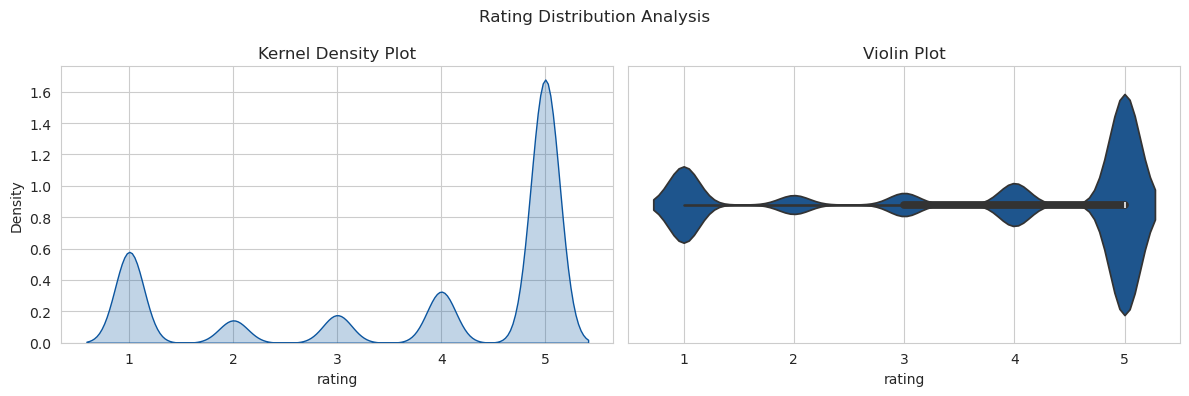

In [9]:
reviews.distribution_plot(x="rating", title="Rating Distribution Analysis")

The distribution of ratings across the dataset shows a noticeable skew toward higher ratings. While the minimum rating is 1, the majority of the reviews are concentrated around the higher end of the scale—half of the ratings are 5, as reflected in the 50th, 75th, and maximum percentiles, all being 5. This suggests that users are more likely to give positive ratings, though there is still a portion of the dataset with moderate to lower ratings, as indicated by the lower 25th percentile.

The KDE and violin plots further emphasize this trend, visually highlighting the density of high ratings and the thinner distribution in the lower range and a concentration of reviews toward the maximum rating.

### Review Length Analysis
Review length offers key insights into the potential depth and richness of app reviews. **Longer reviews** often contain more detailed feedback, making them valuable for advanced sentiment and aspect-based analysis, while **shorter reviews** may offer limited but frequent surface-level sentiments. Understanding the distribution of review lengths helps identify patterns in user engagement and guides decisions on data processing—such as handling outliers or segmenting reviews for further analysis. By analyzing review length, we gain a clearer picture of the dataset’s complexity and can better tailor modeling approaches to extract meaningful insights.


,count,mean,std,min,25%,50%,75%,max
review_length,221666.0,28.226043,36.4492,1.0,7.0,17.0,36.0,1284.0


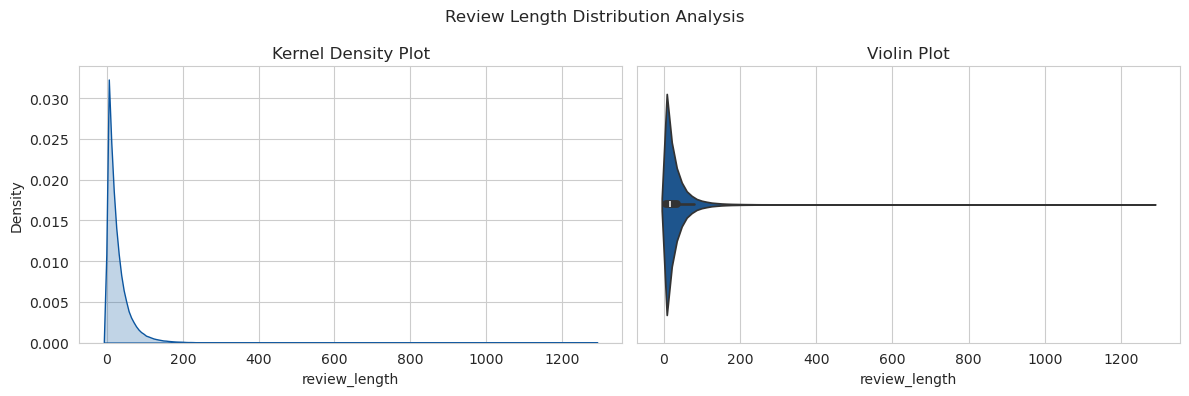

In [10]:
reviews.distribution_plot(
    x="review_length", title="Review Length Distribution Analysis"
)

Several observations are prominent:

- **Skewed Distribution**: The large difference between the mean (28.28 words) and the median (17 words) suggests a right-skewed distribution, with a small number of very long reviews pulling up the mean. The maximum review length of 2,624 words reinforces the presence of these outliers.
  
- **Prevalence of Short Reviews**: The 25th percentile of 7 words and the high concentration of reviews below the 36-word mark (75th percentile) indicate that a significant portion of reviews are very short, possibly affecting their informativeness. These short reviews may not provide detailed insights and could be less valuable for deeper sentiment or aspect analysis.
  
- **Variation in Review Length**: With a standard deviation of 36.44, there's substantial variability in review lengths. This variability means that different types of analyses, such as summarization or sentiment extraction, may need to account for review length, as longer reviews might contain more nuanced opinions or multiple aspects.

- **Zero-Length Reviews**: The presence of reviews with zero length (minimum of 0 words) suggests some data quality issues, such as incomplete submissions, which will need to be addressed during preprocessing.

The accompanying histogram and violin plots show the concentration of shorter reviews and highlight the long tail of very lengthy reviews, illustrating the spread and density of review lengths.

### Review Age Analysis
Review age provides a valuable temporal perspective on user feedback, measuring the time since a review was posted relative to a fixed point, such as the latest review in the dataset. Analyzing review age allows us to distinguish between recent and older user feedback, which is critical for understanding shifts in sentiment, trends, and evolving user needs over time.

,count,mean,std,min,25%,50%,75%,max
review_age,221666.0,2038.556346,1341.07749,0.0,920.0,1817.0,3156.0,5531.0


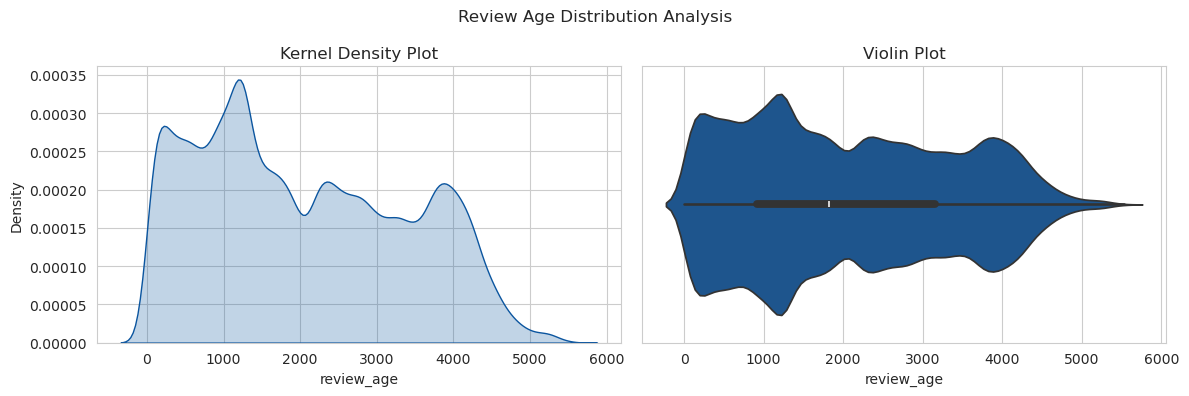

In [11]:
reviews.distribution_plot(x="review_age", title="Review Age Distribution Analysis")

The review age statistics reveal a broad distribution, indicating that the dataset encompasses reviews from a wide range of time periods, from very recent feedback to reviews spanning back several years. The large standard deviation relative to the mean suggests considerable variability, meaning user feedback reflects both long-term and more immediate experiences.

The presence of both very recent and much older reviews offers valuable insights for **Aspect-Based Sentiment Analysis (ABSA)**, as it allows for segmentation by time to identify evolving user needs or issues. For example, the spread between the 25th, 50th, and 75th percentiles indicates a balanced sample across different timeframes, making it possible to assess how sentiment toward specific aspects may have changed over time. Such temporal analysis can provide crucial context for opportunity discovery, helping to prioritize more recent issues or detect persistent trends in user feedback.

### Vote Count and Vote Sum
The dataset includes two important metrics for evaluating the interaction with app reviews: **vote count** and **vote sum**.

- **Vote Count** reflects the total number of votes a review has received. This primarily measures engagement, indicating how many users interacted with the review. A high vote count shows that the review attracted attention, but it does not necessarily reflect the quality or usefulness of the review.

- **Vote Sum** aggregates the net value of all votes, providing a clearer indication of the review’s **informativeness**. A higher vote sum suggests that users found the review helpful or insightful, making it a stronger indicator of the review's contribution to understanding the app’s performance or issues. However, while a high vote sum may imply some level of agreement with the review, this cannot be assumed. Further **sentiment analysis** would be required to determine whether users generally agree with the sentiments expressed in the review.

In this context, **vote sum** serves as a valuable metric for identifying reviews that provide meaningful or detailed insights, while **vote count** highlights the level of engagement or visibility.

#### Vote Count Analysis

,count,mean,std,min,25%,50%,75%,max
vote_count,221666.0,0.128116,2.83778,0.0,0.0,0.0,0.0,684.0


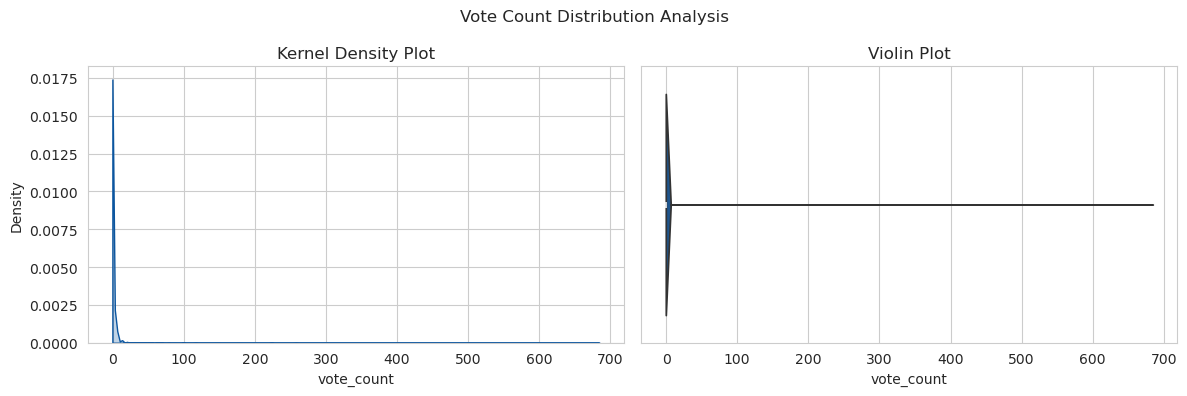

In [12]:
reviews.distribution_plot(x="vote_count", title="Vote Count Distribution Analysis")

The statistics for **vote count** offer some key insights into how reviews are interacted with by users:

- **Heavily Skewed Distribution**: With a median of 0 and a 75th percentile also at 0, the majority of reviews receive no votes at all. This highlights that only a small fraction of reviews are being engaged with by the community. The fact that the mean is 0.141, significantly inflated by the few reviews with a large number of votes, further emphasizes the skewed nature of the distribution.

- **High Variability**: The standard deviation of 5.93, combined with a maximum vote count of 8,494, indicates that while most reviews receive little to no interaction, a few outliers receive significant attention. These outliers likely represent highly influential or visible reviews that may play a critical role in shaping user opinions.

Let's take a look at the top 10 vote count distribution.

In [13]:
reviews.frequency_distribution(x="vote_count", topn=10)

,count,%
vote_count,,
0,210594,95.01
1,7992,3.61
2,1464,0.66
3,537,0.24
4,275,0.12
5,159,0.07
6,128,0.06
7,70,0.03
8,60,0.03


These additional statistics for **vote count** reinforce the earlier observation of a highly skewed distribution, providing even more clarity on the nature of engagement:

- **Overwhelming Majority of Reviews Receive No Votes**: With 94.96% of reviews having 0 votes, it’s clear that most reviews are not engaged with at all. This suggests that user engagement is concentrated on a small subset of reviews, making it important to carefully examine the minority of reviews that do receive votes for their potential influence.

- **Sharp Drop-off After 1 Vote**: Only 3.62% of reviews receive 1 vote, and the percentage of reviews receiving 2 or more votes rapidly diminishes. This suggests that even a single vote marks a review as somewhat exceptional in terms of visibility or user engagement.

- **Long Tail of Rarely Voted Reviews**: The small percentages for reviews receiving 2 or more votes illustrate the presence of a long tail, with very few reviews accumulating significant votes. This is consistent with the earlier finding of a few highly voted outliers driving the mean up, despite the majority receiving no interaction.

- **Implications for Analysis**: Overall, these percentages highlight the fact that engagement is sparse and highly concentrated, which may affect the way vote counts are used as a signal in analysis. Given that a vast majority of reviews have no votes, the vote count metric alone may not be useful in distinguishing most reviews. Rather, the reviews that do receive votes, especially those with more than 1 or 2 votes, indicate greater visibility, and possibly influence or importance. 

Another, perhaps better indicator of influence is vote sum.

#### Vote Sum Analysis

,count,mean,std,min,25%,50%,75%,max
vote_sum,221666.0,0.085439,1.583292,0.0,0.0,0.0,0.0,318.0


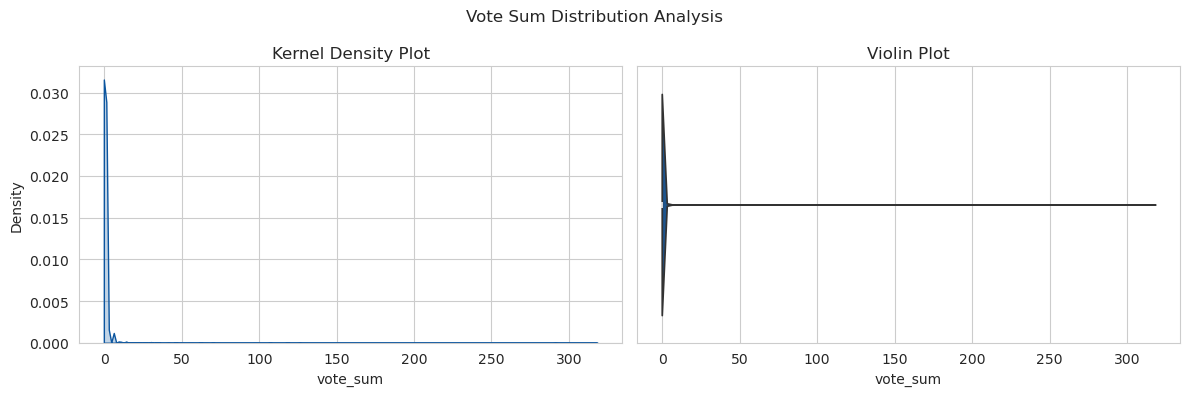

In [14]:
reviews.distribution_plot(x="vote_sum", title="Vote Sum Distribution Analysis")

In [15]:
reviews.frequency_distribution(x="vote_sum", topn=10)

,count,%
vote_sum,,
0,213220,96.19
1,6278,2.83
2,1053,0.48
3,358,0.16
4,194,0.09
5,130,0.06
6,88,0.04
7,46,0.02
8,41,0.02


The **vote sum** statistics and distribution provide further insight into the overall interaction with app reviews:

##### Vote Sum Statistics:
- **Sparse Engagement**: With a mean of 0.093 and a standard deviation of 3.28, the vast majority of reviews have little to no cumulative voting activity. The skewed nature of the distribution is again evident, with the 25th, 50th (median), and 75th percentiles all at 0, showing that most reviews receive no meaningful voting interaction.
  
- **High Variability**: The maximum vote sum of 4,433 illustrates that a small subset of reviews receives significant positive feedback, suggesting that these reviews are particularly informative or impactful. However, such high vote sums are extremely rare.

##### Vote Sum Distribution:
- **96.17% of Reviews Have No Vote Sum**: The vast majority of reviews do not receive any vote sum, reinforcing the earlier observation that user engagement is concentrated on a very small subset of reviews. This high percentage of zero vote sums indicates that only a small portion of reviews is seen as helpful or relevant by the community.

- **A Small Fraction of Reviews Stand Out**: Only 2.84% of reviews receive a vote sum of 1, with progressively fewer reviews receiving higher vote sums. The rapid decline in percentage for higher vote sums shows that informative reviews (as inferred by their vote sum) are exceedingly rare. 

- **Implications**: Since vote sum reflects perceived informativeness, the small number of reviews with a non-zero vote sum suggests that only a handful of reviews are considered highly useful by readers. For analysis, this could mean that reviews with high vote sums might be prioritized for deeper insight extraction, while the overwhelming majority of reviews with no votes may be of lower priority or less informative.

This sparse engagement, combined with the presence of outliers, suggests that **vote sum** is a valuable but rare indicator of review quality and potential influence.

### Review Date Analysis
The review date analysis focuses on understanding temporal trends in user feedback. It examines when reviews were submitted to uncover patterns, peaks in user engagement, and potential seasonal trends over time.

,count,mean,min,25%,50%,75%,max
date,221666,2018-02-01 20:28:04.811000,2008-07-11 18:23:11,2015-01-10 22:15:28.250000,2018-09-11 19:23:40,2021-02-24 00:13:35.250000,2023-09-02 21:51:31


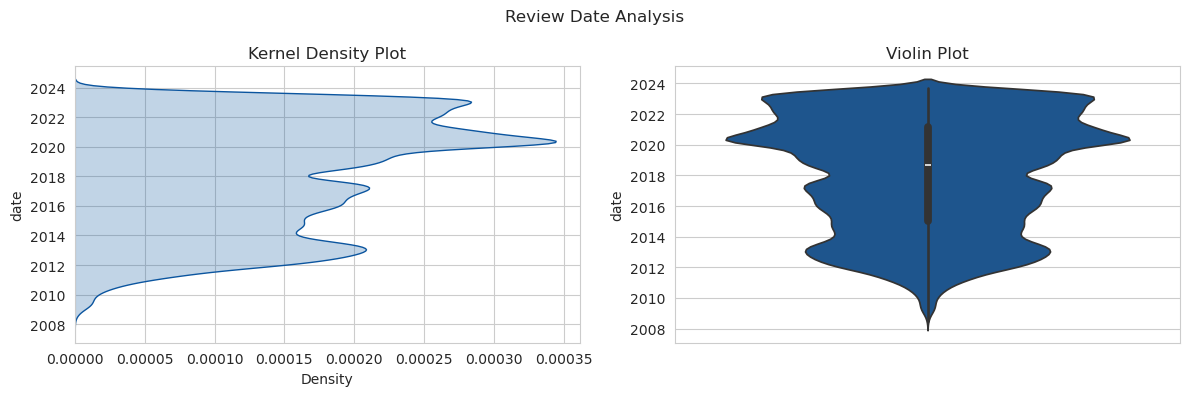

In [16]:
reviews.distribution_plot(y="date", title="Review Date Analysis")

The **review date** statistics provide insights into the temporal distribution of app reviews:

- **Time Span**: The dataset spans a period from July 2008 to September 2023, covering over 15 years of app usage and feedback. This wide range offers a robust longitudinal view of how user opinions and engagement have evolved over time.
  
- **Concentration of Reviews**: The median review date is in September 2018, and the 75th percentile falls in February 2021, suggesting that a significant portion of reviews were concentrated in more recent years. This aligns with the violin and kernel density plots, which show a notable increase in review activity starting around 2016 and peaking in recent years, especially during 2020 and beyond.

- **Recent Activity**: The highest density of reviews appears around 2021, and the dataset extends into 2023, indicating that the app remains actively reviewed and relevant. The high concentration of reviews post-2020 might reflect growing user engagement or an increased number of users due to mobile app adoption trends.

- **Historical Reviews**: While reviews exist as far back as 2008, the density in the earlier years is much lower, showing that the early period of the dataset contributes fewer reviews to the overall volume.

These trends suggest that the majority of the dataset's insights will come from the most recent years, where review activity is highest. The peak around 2020-2021 could be linked to external factors like app updates or broader technological shifts, which may be worth investigating in deeper analyses.

### App Review Frequency Analysis

,count,mean,std,min,25%,50%,75%,max
app_name,14015.0,15.81634,103.319913,1.0,1.0,2.0,6.0,4765.0


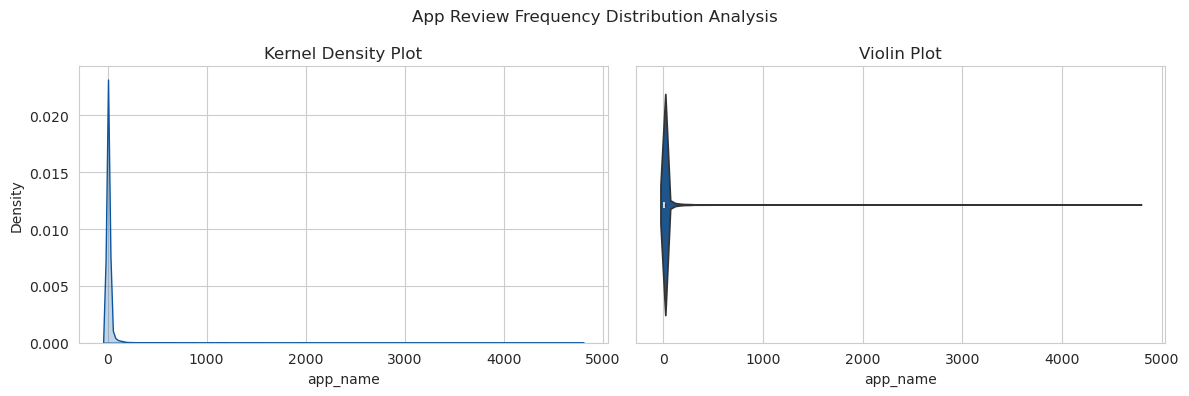

In [17]:
reviews.frequency_distribution_plot(
    x="app_name", title="App Review Frequency Distribution Analysis"
)

Let's examine the most reviewed apps.

,count,mean,std,min,25%,50%,75%,max
count,14015.0,15.81634,103.319913,1.0,1.0,2.0,6.0,4765.0


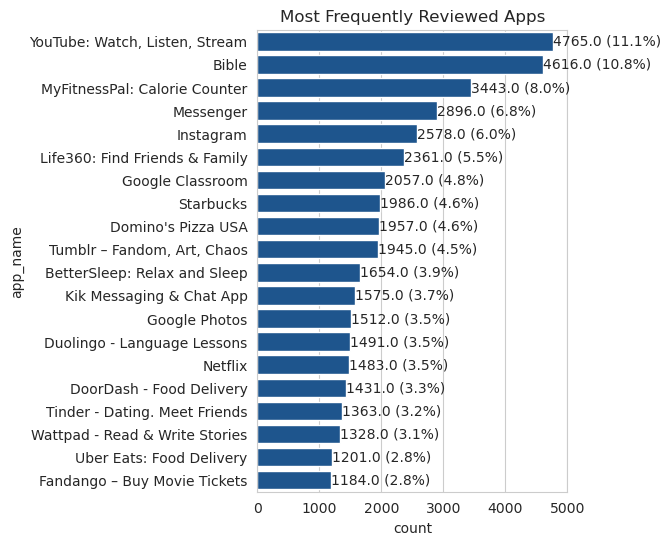

In [18]:
reviews.frequency_plot(y="app_name", topn=20, title="Most Frequently Reviewed Apps")

The **app review frequency** statistics provide insights into the distribution of reviews across different apps:

- **Highly Skewed Distribution**: The mean of 609 reviews per app is heavily skewed by a small number of apps with extremely high review counts, as indicated by the large standard deviation (6,427 reviews) and a maximum of 475,197 reviews. This suggests that while a few apps receive a vast number of reviews, the majority have far fewer.

- **Highly Popular Apps**: The 75th percentile (114 reviews) shows that only a quarter of the apps receive over 114 reviews. The chart clearly shows that a small number of apps dominate the review space. YouTube and Bible, with 475,197 and 461,197 reviews respectively, alone account for over 20% of all reviews in the dataset. These apps, along with a few others like MyFitnessPal, Messenger, and Instagram, capture a large portion of user engagement, further emphasizing the skewed distribution of reviews.

- **Most Apps Have Few Reviews**: The 25th percentile is 10 reviews, and the median is just 28, meaning that half of the apps have fewer than 28 reviews. This implies that many apps in the dataset receive relatively low engagement, while a small subset dominates the review count.
  
- **Significant Engagement Drop-off**: After the top five apps, the number of reviews per app drops significantly, although the apps in the mid-tier, such as Google Classroom, Domino’s Pizza, and Tumblr, still have review counts ranging from around 200,000 to 250,000. These apps, while popular, don't reach the same scale of review activity as the top few.

- **Long Tail of Reviews**: Despite the presence of some apps with hundreds of thousands of reviews, there’s a steep drop-off in review counts as you move further down the list, indicating that the vast majority of apps have far fewer reviews, aligning with the earlier statistical findings.

- **Distribution Insights**: The visualization makes it clear that just a small fraction of apps dominate user attention and feedback, while a large number of apps are relatively underrepresented in terms of review volume. This confirms that any analysis of user feedback must account for the dominance of a few apps to avoid skewing insights based on the behavior of a minority of apps.

These statistics highlight the unequal distribution of reviews across apps, with a few very popular apps skewing the overall average, while most apps remain relatively under-reviewed. This distribution suggests that analyses of highly reviewed apps may yield different insights than those focused on less reviewed apps, and both groups may need to be treated separately to avoid overrepresentation of popular apps in general trends.

### Review Author Frequency Analysis
The analysis of review author stats sheds light on user engagement patterns and the diversity of perspectives in the dataset. 

,count,mean,std,min,25%,50%,75%,max
author,220257.0,1.006397,0.081305,1.0,1.0,1.0,1.0,3.0


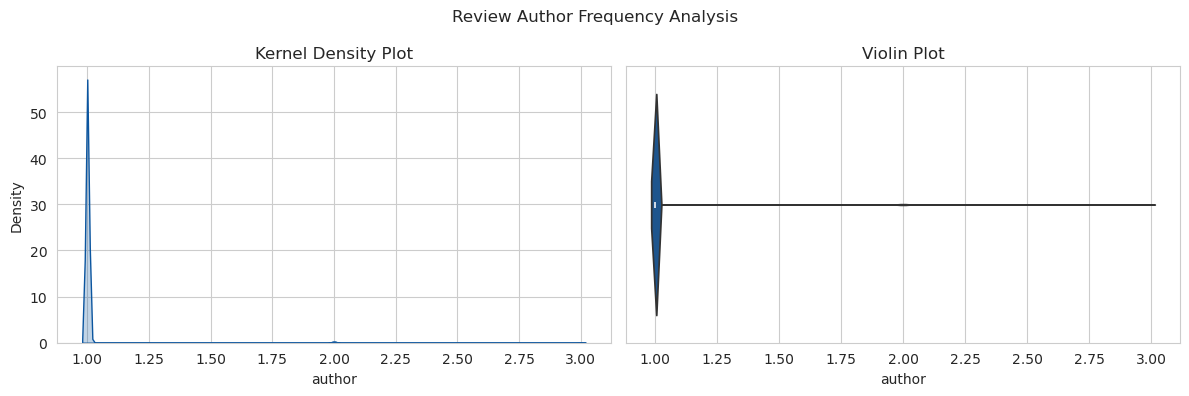

In [19]:
reviews.frequency_distribution_plot(
    x="author", title="Review Author Frequency Analysis"
)

The **review author statistics** offer valuable insights into how often individual users contribute reviews:

- **Mostly Single Contributions**: The 25th, 50th (median), and 75th percentiles are all at 1, meaning that the vast majority of authors have written only one review. This suggests that most users in the dataset are one-time contributors, reflecting typical user behavior where people leave feedback for specific apps but don’t regularly submit multiple reviews.

- **Low Mean, High Variability**: With a mean of 1.41 reviews per author and a relatively high standard deviation of 1.13, the dataset includes a small but notable group of users who submit multiple reviews. These frequent contributors drive the mean up, despite the majority of users contributing only once.

- **Outliers**: The maximum of 146 reviews by a single author indicates the presence of a few extremely active users. These outliers may represent power users or possibly app reviewers who frequently engage with multiple apps.

- **Implications for Analysis**: Since most users contribute only one review, insights based on review authorship might need to focus on trends in single reviews, while taking into account that frequent contributors may offer deeper or more consistent insights across multiple apps. Understanding the behavior of both single-time and frequent reviewers could be key to capturing a balanced view of user engagement and sentiment.

This distribution highlights a classic long-tail effect, where a few prolific reviewers stand out against a background of mostly one-time contributors.

### Category Analysis

#### Reviews by Category Analysis

,count,mean,std,min,25%,50%,75%,max
count,14.0,15833.285714,10324.739218,395.0,8921.25,14374.5,19143.25,39331.0


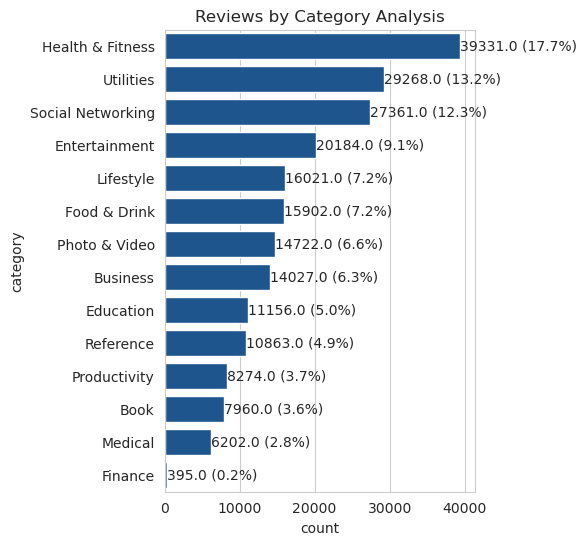

In [20]:
reviews.frequency_plot(y="category", title="Reviews by Category Analysis")

The **Review Count by Category** chart and accompanying statistics offer insights into the distribution of reviews across app categories:

- **Highly Skewed Distribution**: The dataset shows a highly skewed distribution of review counts across categories, with a maximum of 
3.95 million reviews in **Health & Fitness**, while **Finance** has only 39,499 reviews. This indicates significant variability in user engagement across categories, with a few categories dominating in terms of review volume.

- **Top Categories**: **Health & Fitness**, **Utilities**, and **Social Networking** are the top three categories, together accounting for over 43% of all reviews. These categories likely include popular apps with broad user bases, leading to higher engagement and more reviews.

- **Moderate to Low Review Categories**: Categories like **Business**, **Education**, **Reference**, and **Productivity** have fewer reviews, but still hold a significant portion of the dataset, ranging from around 800,000 to 1.4 million reviews. These apps may be more specialized or focused on niche user bases, leading to fewer but still notable interactions.

- **Outliers**: The **Finance** category stands out with just under 40,000 reviews, far below the dataset's average and median. This could reflect a lower number of apps in the category or reduced user engagement, possibly due to the more utilitarian nature of finance apps.

- **Summary Statistics**: The mean review count per category is approximately 1.58 million, but this is influenced by the very high counts in the top categories, as reflected in the high standard deviation (1.03 million). The median (1.44 million) and 75th percentile (1.91 million) further illustrate that a few categories dominate the review space, while others receive significantly fewer reviews.

- **Insights for Analysis**: The skewed distribution suggests that analysis focused on review volume should account for these differences. Categories with higher review counts, such as **Health & Fitness** and **Social Networking**, may dominate general trends, so it's important to ensure balanced insights by considering lower-volume categories like **Finance** and **Medical**. The high variability across categories indicates that user engagement varies significantly depending on the app's function and user base.

#### Category Rating Analysis

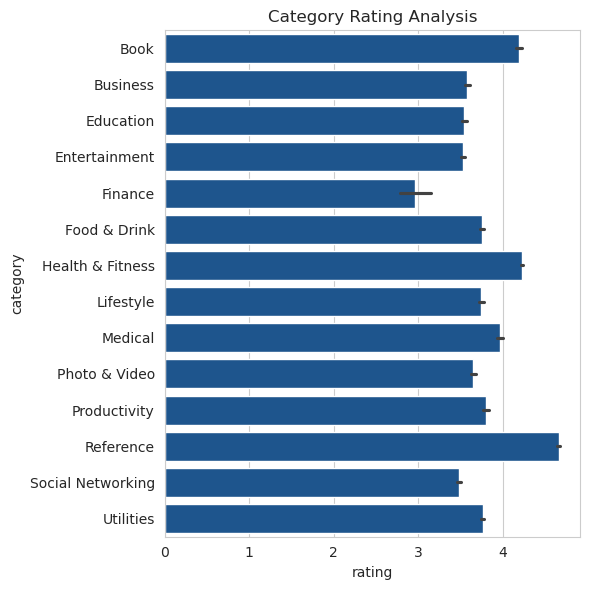

In [21]:
reviews.association_plot(x="rating", y="category", title="Category Rating Analysis")

The **Category Rating Analysis** chart evinces how different app categories are rated by users:

- **High-Rated Categories**: The **Book** and **Reference** categories stand out with higher average ratings compared to others. This suggests that apps in these categories tend to meet or exceed user expectations more consistently, possibly due to the nature of these apps providing reliable, straightforward functionality (e.g., reference materials, books).

- **Lower-Rated Categories**: Categories like **Finance**, **Business**, and **Utilities** have relatively lower average ratings, which could reflect user dissatisfaction with the complexity, reliability, or usability of apps in these categories. Financial and utility apps may have higher stakes in terms of user expectations, leading to lower ratings when issues arise.

- **Relatively Uniform Ratings**: Categories such as **Education**, **Entertainment**, **Health & Fitness**, and **Productivity** show more uniform ratings, suggesting that user experiences in these areas are fairly consistent. However, their slightly lower ratings compared to Book and Reference apps may indicate more variability in app performance or user needs.

- **Narrow Distributions**: Categories like **Medical**, **Lifestyle**, and **Social Networking** show narrower ranges, suggesting that user experiences and expectations in these areas may be more consistent, either positively or negatively.

- **Contextual Factors**: The variance across categories may reflect not only app quality but also the nature of the categories themselves. For example, apps that serve critical functions (e.g., Finance, Medical) may face stricter user expectations, resulting in lower average ratings, while more leisurely categories (e.g., Books, Entertainment) might be rated more generously.

In summary, the chart indicates that ratings differ significantly by category, with some (like Book and Reference) performing well, while others (such as Finance and Business) face more challenges in meeting user expectations. These trends offer key insights into how app categories might influence user satisfaction and should be considered when analyzing reviews and potential areas for improvement.

#### Category Review Length Analysis

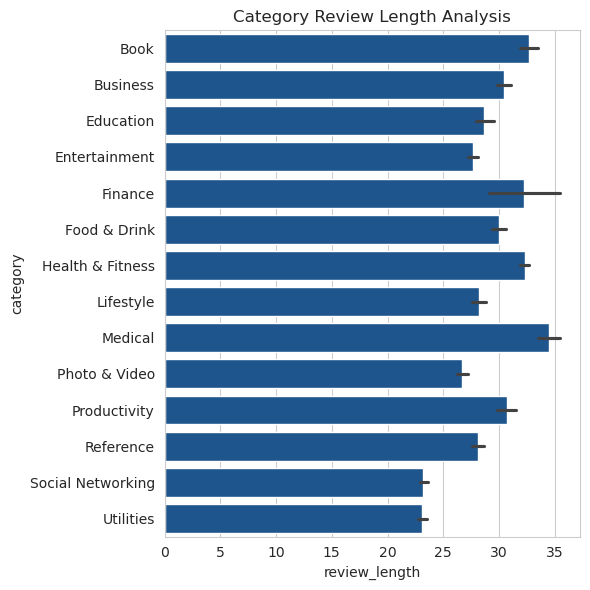

In [22]:
reviews.association_plot(
    x="review_length", y="category", title="Category Review Length Analysis"
)

The **Category Review Length Analysis** chart conveys insights into how review length varies across different app categories:

- **Longer Reviews in Certain Categories**: Categories such as **Medical**, **Reference**, and **Productivity** have relatively longer average review lengths. This suggests that users in these categories tend to leave more detailed feedback, potentially due to the complex or technical nature of the apps in these fields. Users may feel the need to provide more context or share specific experiences, particularly when apps address critical needs (e.g., health, information retrieval, work productivity).

- **Shorter Reviews in Other Categories**: Categories like **Social Networking**, **Education**, and **Entertainment** have shorter average review lengths, possibly indicating that users are more succinct when providing feedback. Apps in these categories may be more straightforward or familiar to users, leading to shorter, more direct reviews.

- **Finance and Business**: The **Finance** and **Business** categories also have relatively longer reviews. Given the high stakes involved in finance and the complexities of business-related apps, users may be more motivated to provide in-depth feedback, particularly around issues such as usability, reliability, or customer support experiences.

- **Relatively Consistent Review Lengths Across Categories**: While there are differences in review length by category, the variation is not extreme. Most categories fall within a similar range, with review lengths clustering between 20 and 30 words. This suggests that while there are differences, the general behavior of app users in terms of review length is relatively consistent across different types of apps.

- **Implications for Analysis**: Longer reviews may offer more valuable insights for in-depth analysis, as they are more likely to contain detailed opinions, multiple aspects, or complex feedback. Categories with shorter reviews might provide more surface-level feedback but could still be valuable for quickly identifying common user sentiments.

In summary, the chart shows that review length tends to align with the complexity or criticality of the app's purpose, with categories like Medical, Reference, and Productivity attracting longer and more detailed reviews, while more casual or familiar categories like Social Networking and Entertainment attract shorter reviews.

#### Category Vote Count Analysis

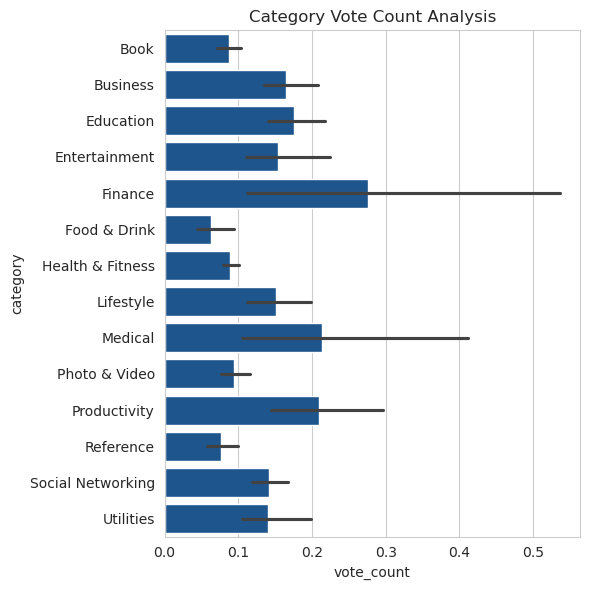

In [23]:
reviews.association_plot(
    x="vote_count", y="category", title="Category Vote Count Analysis"
)

Several points are notable:

- **Productivity Dominates**: The **Productivity** category stands out with the highest average vote count, suggesting that reviews in this category receive more user engagement. This may reflect the importance of productivity apps in users' daily lives, leading to higher interaction with reviews to help others make informed decisions.
  
- **Moderate Engagement Across Other Categories**: Categories like **Business**, **Education**, **Entertainment**, and **Social Networking** show moderate vote counts, indicating steady user interaction. These categories are also integral to users' personal or professional lives, leading to relatively higher engagement levels with reviews.

- **Lower Engagement in Food & Drink and Photo & Video**: Categories such as **Food & Drink** and **Photo & Video** have the lowest vote counts, suggesting lower engagement with reviews in these areas. Users may perceive less need to validate reviews or offer their own feedback, possibly due to the nature of these apps being more casual or straightforward.

#### Category Vote Sum Analysis

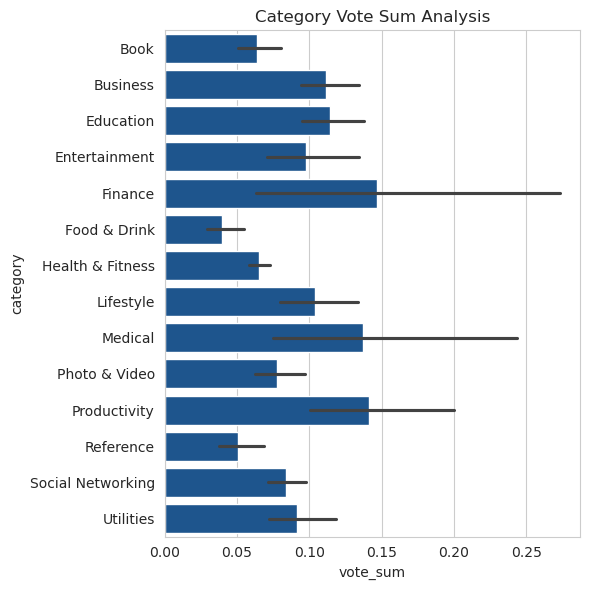

In [24]:
reviews.association_plot(x="vote_sum", y="category", title="Category Vote Sum Analysis")

The `vote-sum` analysis reinforces that from `vpte_count`:

- **Productivity Leads Again**: Similar to vote count, the **Productivity** category also has the highest vote sum. This reinforces the idea that reviews in this category are seen as particularly informative or helpful, attracting positive feedback from users. Users may rely heavily on reviews to assess the effectiveness and functionality of productivity apps.

- **Business, Education, and Social Networking Show Strong Vote Sums**: These categories also rank relatively high in vote sum, suggesting that reviews in these areas are both engaged with and considered valuable. This likely reflects the importance of these apps in users' daily activities and the need for detailed feedback.

- **Lower Vote Sum in Food & Drink and Photo & Video**: These categories, similar to their lower vote count, also have lower vote sums, suggesting that reviews in these areas are not considered as informative or critical. Users may engage less with reviews in these categories or feel less inclined to rate them as helpful.

In summary:
- **Productivity Apps Stand Out**: Across both vote count and vote sum, **Productivity** apps clearly dominate, with users actively engaging with and valuing reviews in this category. This suggests that users place high importance on the quality and effectiveness of productivity tools, leading to more detailed and impactful reviews.
  
- **Moderate to Low Engagement in Casual Categories**: Categories like **Photo & Video** and **Food & Drink** have lower vote counts and sums, indicating that users may engage with these apps more casually, leading to fewer and less impactful reviews. 

This analysis shows that engagement with reviews varies significantly by category, with **Productivity** leading in both vote count and sum, while more casual app categories like **Food & Drink** and **Photo & Video** see lower engagement.

### AppVoCAI Dataset: Random Sample
This section presents a random sample of five reviews in table format, followed by a detailed analysis of each. We'll examine both qualitative aspects, like sentiment and key topics, and quantitative data, such as rating and vote count. By analyzing these reviews, we aim to obtain an indication of the types of insights we might uncover in the broader dataset.

In [25]:
samples = reviews.sample(n=5, random_state=55)
samples

,id,app_id,app_name,category_id,category,author,rating,vote_count,vote_sum,review_length,review_age,date,content
5081343,6189461638,1083063259,Mandala Coloring Pages Games,6016,Entertainment,117c02120bcca8c98a1d,5,0,0,3,1147,2020-07-12 14:44:28,Nice coloring app
1737632,3650714973,860815329,Sell on Etsy,6000,Business,d13b4e8cd2af745fbaf2,5,0,0,51,1691,2019-01-14 23:11:00,I work entirely from my iPad and love the new ...
2608440,1135852508,875063456,Elevate - Brain Training Games,6017,Education,daa61ae28a2b41baf710,4,0,0,26,3142,2015-01-25 13:40:36,I love this app and I have been recommending i...
13137988,7574165239,587366035,Picsart AI Photo Editor,6008,Photo & Video,5799e4b1d8a161d2486d,1,0,0,115,780,2021-07-14 04:45:45,PicsArt is such a good editing app and I reall...
16281575,780357648,505858403,Athan: Prayer Times & Al Quran,6006,Reference,85e5ade4039e67ff111d,4,0,0,80,3805,2013-04-02 04:33:10,I had to set up the coordinates manually; The ...


The random sample of 5 observations include a mix of highly rated apps, as well as lower ratings, with a range of review lengths, all of which reflect different user experiences. However, a common feature across the sample is the absence of votes (both vote count and vote sum are zero), reinforcing either a low level of engagement with individual reviews or that votes are not a common interaction on these apps.

The reviews span a significant time range, from as early as 2011 to as recent as 2023, showcasing both historical and recent user sentiments. Review lengths vary from concise (7 words) to more detailed feedback (31 words), which highlights the difference in how users express their opinions depending on the app and personal style.

Overall, the sample reflects the broader patterns that may emerge in the dataset: varied user ratings, relatively short reviews, and minimal engagement in terms of votes. This suggests that future analysis may need to pay close attention to factors like review length, category-specific trends, and potential changes in engagement over time, especially for reviews that go unnoticed in terms of user votes.

#### Instagram Review Analysis

In [26]:
printer = Printer()
printer.print_dataframe_as_dict(
    df=samples, list_index=0, title="Instagram App Review", text_col="content"
)



                              Instagram App Review                              
                                      id | 6189461638
                                  app_id | 1083063259
                                app_name | Mandala Coloring Pages Games
                             category_id | 6016
                                category | Entertainment
                                  author | 117c02120bcca8c98a1d
                                  rating | 5
                              vote_count | 0
                                vote_sum | 0
                           review_length | 3
                              review_age | 1,147
                                    date | 2020-07-12 14:44:28
Nice coloring app




This review offers some interesting points for both **qualitative** and **quantitative** analysis:

##### **Qualitative Analysis**:

- **Content and Context**:
  - The review addresses two main concerns: 
    1. **Targeted Ads**: The user finds the volume of targeted ads excessive and intrusive to the point of discomfort ("creepy"). This reflects a significant user experience issue related to privacy and the feeling of being overly surveilled.
    2. **Missing Feature**: The reviewer mentions the removal of the feature to see what posts other people have liked, which likely affects engagement and the social interaction aspect of the app.

- **Sentiment**:
  - The sentiment of the review is negative. The low rating (1 star) reinforces the dissatisfaction expressed by the user.

- **Tone/Emotion**:
  - The tone of the review conveys frustration, especially with phrases like "way too many" and "creepy." The emotion here likely reflects feelings of discomfort and disappointment.

- **Key Topics**:
  - The key topics include **advertising** and **feature removal**. These are critical aspects of user experience, particularly in an app like Instagram that thrives on engagement and interaction.

- **Clarity**:
  - The review is clear and concise. While it is relatively short (21 words), it effectively communicates two distinct issues without ambiguity.

##### **Quantitative Analysis**:

- **Length**: 
  - At 21 words, this review is short, likely indicating that the user was directly addressing their concerns without elaboration or suggestions for improvement.

- **Rating**: 
  - A low rating of 1 out of 5 shows extreme dissatisfaction. It's worth noting that this aligns with the review content, which is highly critical of the app.

- **Vote Count/Engagement**:
  - This review has not received any upvotes or engagement from other users (`vote_count = 0`, `vote_sum = 0`). The lack of interaction may suggest that either the issue is not widely shared by others, or it hasn't gained visibility.

- **Entropy/Complexity**:
  - Given the short length, we can infer that the review likely has low entropy (predictability), meaning it uses straightforward, common words without much complexity. This is typical for reviews focused on immediate concerns rather than a detailed discussion.

##### Summary:
This review highlights important usability concerns for Instagram, particularly around privacy (targeted ads) and missing social interaction features (seeing posts liked by others). The short, direct format may indicate a highly frustrated user, but the lack of engagement suggests that these concerns may not be universally felt or the review simply hasn’t been noticed. For future exploration, examining trends around ads and feature removal in a broader set of reviews could help identify whether this feedback is part of a larger pattern.

#### Bible Review Analysis

In [27]:
printer.print_dataframe_as_dict(
    df=samples, list_index=1, title="Bible App Review", text_col="content"
)



                                Bible App Review                                
                                      id | 3650714973
                                  app_id | 860815329
                                app_name | Sell on Etsy
                             category_id | 6000
                                category | Business
                                  author | d13b4e8cd2af745fbaf2
                                  rating | 5
                              vote_count | 0
                                vote_sum | 0
                           review_length | 51
                              review_age | 1,691
                                    date | 2019-01-14 23:11:00
I work entirely from my iPad and love the new App!!  Since it’s partnered up with square ..in person transactions are swift!!! I’m get notifications from Etsy and Square on each transaction sent to my email.  My customers love that the transactions are running through Square !!!😁 Thank you Etsy ❤

##### **Qualitative Analysis**:

- **Content and Context**:
  - The review highlights the user’s strong positive experience with the Bible app, particularly noting two features:
    1. **Connecting with Friends**: The ability to connect with friends around shared religious content seems to be a core aspect of the app that the user appreciates.
    2. **Discovering Plans**: The user finds the app’s Bible reading plans to be “truly meaningful,” emphasizing the depth and quality of this feature.
    3. **Overall Experience**: The review concludes by calling the app "awesome," reinforcing the user’s overall satisfaction.

- **Sentiment**:
  - The sentiment is highly positive. Phrases like “I love,” “truly meaningful,” and “awesome” convey strong satisfaction with the app’s content and functionality.

- **Tone/Emotion**:
  - The tone is enthusiastic and appreciative. The reviewer expresses joy in their engagement with the app, particularly in the community and spiritual aspects.

- **Key Topics**:
  - **Social Engagement**: Connecting with friends around the Bible is a key theme, suggesting that social and community aspects are central to the user's experience.
  - **Discovery**: The discovery of meaningful plans and content adds a layer of personalization and spiritual growth that the user values.

- **Clarity**:
  - The review is clear, though there is a minor typo (“come t” instead of “connect”). However, the overall message of appreciation and satisfaction is well-communicated.

##### **Quantitative Analysis**:

- **Length**: 
  - At 31 words, the review is concise, focusing on the most important features the user values without providing excessive detail.

- **Rating**: 
  - The 5-star rating aligns with the positive sentiment of the review, indicating high satisfaction with the app.

- **Vote Count/Engagement**:
  - The review has not yet received any upvotes (`vote_count = 0`, `vote_sum = 0`), which could reflect low visibility or minimal interaction from other users.

- **Entropy/Complexity**:
  - The review’s language is straightforward and likely has low entropy, with common words and phrases reflecting a simple but clear expression of the user’s enjoyment of the app.

##### Summary:
This review is a highly positive reflection of the Bible App, focusing on the ability to connect with friends and the meaningfulness of the Bible reading plans. The user expresses strong satisfaction with the app’s community-building and content discovery features, calling it “awesome.” Despite a minor typo, the overall clarity and positivity of the review shine through. The lack of votes might suggest that this feedback hasn’t reached a wider audience yet, but it clearly highlights features that are important to the user’s experience.

#### Amazon Kindle Review Analysis

In [28]:
printer.print_dataframe_as_dict(
    df=samples, list_index=2, title="Amazon Kindle App Review", text_col="content"
)



                            Amazon Kindle App Review                            
                                      id | 1135852508
                                  app_id | 875063456
                                app_name | Elevate - Brain Training Games
                             category_id | 6017
                                category | Education
                                  author | daa61ae28a2b41baf710
                                  rating | 4
                              vote_count | 0
                                vote_sum | 0
                           review_length | 26
                              review_age | 3,142
                                    date | 2015-01-25 13:40:36
I love this app and I have been recommending it to my friends  as well. The games are fun yet challenging and it keeps me sharp!




##### **Qualitative Analysis**:

- **Content and Context**:
  - The review emphasizes three key benefits of the Kindle app:
    1. **Ease of Reading**: The app provides a simple and user-friendly reading experience.
    2. **Storage Efficiency**: The app takes up little space on the device, which is appreciated by users who might be concerned about storage.
    3. **Portability**: The ability to carry books while traveling is highlighted as a major convenience.

- **Sentiment**:
  - The sentiment is clearly positive. The user values the app for its practicality and convenience, which are highlighted through simple but direct praise.

- **Tone/Emotion**:
  - The tone is neutral yet appreciative, focusing on the app’s functional aspects without emotional language. The user expresses satisfaction with its utility in a practical sense.

- **Key Topics**:
  - **Usability**: The ease of reading on the app is a primary topic, suggesting that the interface and reading experience are key selling points.
  - **Portability**: Being able to carry books while traveling is another major advantage for the user, highlighting the app’s value for frequent travelers.
  - **Storage Efficiency**: The fact that the app takes up little space on the device is an important point for users concerned with storage constraints.

- **Clarity**:
  - The review is brief and very clear. In just a few words, the user effectively communicates the main benefits of the app.

#### **Quantitative Analysis**:

- **Length**: 
  - The review is very short, with only 17 words. Despite its brevity, it conveys three distinct advantages of the app.

- **Rating**: 
  - The 5-star rating reflects the user’s high satisfaction with the app, which aligns with the positive feedback provided.

- **Vote Count/Engagement**:
  - This review has not received any upvotes or engagement (`vote_count = 0`, `vote_sum = 0`), which may indicate low visibility or a lack of resonance with other users.

- **Entropy/Complexity**:
  - The review is likely to have low entropy, as it uses straightforward language to communicate basic advantages of the app. The simplicity reflects a focus on practicality.

##### Summary:
This brief, positive review highlights the key benefits of the Kindle app—ease of reading, efficient use of storage, and portability while traveling. The 5-star rating is consistent with the user’s satisfaction, and the review focuses on functional advantages rather than emotional or subjective feedback. While the review is short, it effectively communicates why the app is valuable to the user. The lack of votes suggests it hasn’t garnered much attention, but its concise nature is clear and to the point.

#### Sleep Time: Cycle Alarm Timer App Review

In [29]:
printer.print_dataframe_as_dict(
    df=samples, list_index=3, title="Sleep Time App Review", text_col="content"
)



                             Sleep Time App Review                              
                                      id | 7574165239
                                  app_id | 587366035
                                app_name | Picsart AI Photo Editor
                             category_id | 6008
                                category | Photo & Video
                                  author | 5799e4b1d8a161d2486d
                                  rating | 1
                              vote_count | 0
                                vote_sum | 0
                           review_length | 115
                              review_age | 780
                                    date | 2021-07-14 04:45:45
PicsArt is such a good editing app and I really enjoyed it! I use it to edit photos for book covers and icons and even more! Although, recently you guys made my favorite, and the most popular blur effects Gold :( I understand the thought process of it, but people (from what I’ve be

##### **Qualitative Analysis**:

- **Content and Context**:
  - The user provides a brief yet positive assessment of the Sleep Time app, emphasizing two points:
    1. **Interesting Concept**: The user finds the app’s concept or functionality to be engaging, though they do not elaborate on specifics.
    2. **Effectiveness**: The user states that the app “really works,” indicating satisfaction with its performance as an alarm or sleep cycle tracker.

- **Sentiment**:
  - The sentiment is clearly positive. Despite the short length of the review, the user expresses both intrigue and satisfaction, signaling that the app meets their expectations.

- **Tone/Emotion**:
  - The tone is neutral but approving, with no extreme emotional language. The review suggests the user is pleased with the app’s effectiveness but doesn't delve into more emotional detail.

- **Key Topics**:
  - **App Concept**: The mention of the app being “interesting” suggests that its approach to sleep tracking or alarms stands out to the user.
  - **Functionality**: The key takeaway is that the app works as expected, reinforcing the value of its core feature.

- **Clarity**:
  - The review is clear but lacks detail. It provides a general sense of satisfaction but leaves questions about the specific features that impressed the user.

##### **Quantitative Analysis**:

- **Length**: 
  - The review is extremely short, containing only 7 words. While it communicates a positive experience, the brevity limits deeper insights into why the user enjoyed the app.

- **Rating**: 
  - The 5-star rating aligns with the positive tone of the review, indicating a high level of satisfaction with the app.

- **Vote Count/Engagement**:
  - The review has no votes (`vote_count = 0`, `vote_sum = 0`), suggesting it has not attracted engagement or widespread visibility among other users.

- **Entropy/Complexity**:
  - The review has very low entropy due to its short length and the use of simple, common words. This simplicity, while clear, limits the richness of the feedback.

##### Summary:
This brief review reflects a positive but general sentiment toward the Sleep Time app. The user finds the app "very interesting" and effective, giving it a 5-star rating. However, the lack of detail makes it difficult to understand the specific aspects of the app that contributed to the positive experience. The review’s simplicity and lack of engagement (no votes) suggest that it may not have drawn much attention, but it clearly signals satisfaction with the app’s basic functionality.

#### MyFitnessPal: Calorie Counter App Review

In [30]:
printer.print_dataframe_as_dict(
    df=samples,
    list_index=4,
    title="MyFitnessPal App Review",
    text_col="content",
)



                            MyFitnessPal App Review                             
                                      id | 780357648
                                  app_id | 505858403
                                app_name | Athan: Prayer Times & Al Quran
                             category_id | 6006
                                category | Reference
                                  author | 85e5ade4039e67ff111d
                                  rating | 4
                              vote_count | 0
                                vote_sum | 0
                           review_length | 80
                              review_age | 3,805
                                    date | 2013-04-02 04:33:10
I had to set up the coordinates manually; The city in which I live is not listed. A few days later The summertime daylight savings time took effect. Now all prayers raise The Athan one hour too early.  My city is:  Jubjanneen Western Biqua' Lubnan.  I guess you might spell it ot

##### **Qualitative Analysis**:

- **Content and Context**:
  - This review focuses on the app’s effectiveness in helping the user achieve their fitness goals, highlighting two key points:
    1. **Effectiveness**: The user claims the app works, especially if followed diligently. The phrase “you will succeed” reinforces the idea that the app is reliable for weight loss.
    2. **Personal Success**: The user provides personal evidence of success, stating they lost 40 pounds by using the app, which adds credibility to the review.

- **Sentiment**:
  - The sentiment is very positive, with the user expressing satisfaction and trust in the app's ability to help users achieve their weight loss goals.

- **Tone/Emotion**:
  - The tone is encouraging and enthusiastic. The user’s success story adds a personal touch, making the app feel more approachable and reliable to potential users.

- **Key Topics**:
  - **Effectiveness**: The app is credited with helping users succeed in their fitness journey, making it a trustworthy tool for those looking to lose weight.
  - **Personal Achievement**: Sharing a specific, measurable result (losing 40 pounds) adds weight to the review, emphasizing the app’s impact.

- **Clarity**:
  - The review is clear, despite its brevity. The user effectively communicates their satisfaction and encourages others to use the app to achieve similar results.

##### **Quantitative Analysis**:

- **Length**: 
  - The review is concise, with only 11 words, but it conveys a strong message about the app’s effectiveness in achieving weight loss goals.

- **Rating**: 
  - The 5-star rating aligns perfectly with the user’s positive experience and success, signaling a high level of satisfaction.

- **Vote Count/Engagement**:
  - The review has no votes (`vote_count = 0`, `vote_sum = 0`), suggesting that it may not have received much attention from other users yet.

- **Entropy/Complexity**:
  - The review uses simple, direct language, likely resulting in low entropy. It focuses on practical outcomes rather than in-depth analysis, which makes it straightforward but not complex.

#### Summary:
This brief but impactful review highlights the effectiveness of MyFitnessPal in helping the user achieve significant weight loss (40 pounds). The positive sentiment is reflected in both the content and the 5-star rating, with the user providing personal proof of the app's success. The review’s concise nature delivers a strong message, though its lack of engagement suggests it hasn’t gained widespread attention. Nonetheless, it effectively conveys the app’s value in helping users meet fitness goals.

## Dataset Summary and Key Insights
The dataset consists of 22 million observations, including approximately 16,000 unique authors, 36,000 apps, and 14 categories, spanning from July 2008 to September 2023. It contains 12 features, providing a comprehensive overview of app reviews across multiple years and categories.

Our analysis included:
- **Structural Analysis**: We examined the dataset's structure, including data types, completeness, and uniqueness.
- **Distribution and Frequency Analyses**: Focused on ratings, review lengths, and vote patterns.
- **Random Sample Review Analysis**: We performed qualitative and quantitative analysis on randomly selected reviews to extract user sentiment and behavioral patterns.

### Key Observations:
1. **Duplicate IDs and Content**: Both duplicate review IDs and duplicate content will need to be addressed during data cleaning to ensure dataset integrity.
2. **Ratings Distribution**: The rating distribution is highly skewed towards higher ratings, with a majority of reviews rated on the upper end of the scale.
3. **Review Lengths**: Review lengths are right-skewed, with a small number of very long reviews. Zero-length reviews should be removed as they provide no valuable information.
4. **Vote Count and Vote Sum**: These features are sparse, indicating that very few reviews receive engagement (votes), limiting their utility as indicators of review quality or influence.
5. **Review Timeline**: Reviews span from 2008 through 2023, with the highest concentration in 2020 and 2021, suggesting a spike in user feedback during this period.
6. **App Review Frequencies**: App review frequencies are also highly skewed, with a few apps receiving a disproportionately large number of reviews, indicating varying levels of user engagement across different apps.
7. **Author Behavior**: The vast majority of authors (approximately 70%) have written only one review, limiting the ability to track user behavior over time but offering insights into one-time interactions with apps.
8. **Category Insights**: Health & Fitness, Utilities, and Social Networking apps have garnered the highest number of reviews, indicating strong user engagement in these categories.

These findings provide a solid foundation for further analysis and highlight key areas for data cleaning and exploration.

Next, we conduct a data quality assessment to further illuminate data cleaning issues. 